In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import datetime
from collections import defaultdict

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk import ngrams

# Gensim
import gensim
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt 

from scipy.stats import pearsonr

import statsmodels
from statsmodels.tsa.stattools import grangercausalitytests

/home/jagaskak/.local/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
'''
This cell contains the processing of NYTimes data and IEM stock market data. You should only run this once.
'''

stop_words = stopwords.words('english')
stop_words.extend(['mr', 'ms', 'mrs', 'said'])

# Tokenize and remove stop words from content
def tokenize(content, lemmatize=False):
    words = gensim.utils.simple_preprocess(content, deacc=True)  # tokenizes
    return words

def remove_stopwords(content):
    words = []
    for word in content:
        if word in stop_words:
            continue
        words.append(word)
    return words


'''
Retrieve Data from files
'''

# New York Times Data
rows = []
dates = []
articles = []
for month in range(5, 11):
    with open("Data/NYTimes/"+ str(month) + ".txt") as f:
        for i, line in enumerate(f):
            date, article = line.split(",", 1)
            timestamp = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S%z").date()
            tokenized = tokenize(article)
            destopped = remove_stopwords(tokenized)

            articles.append(destopped)
            dates.append(timestamp)
            rows.append([timestamp, destopped])

nytimes = pd.DataFrame(rows, columns=["Date", "Content"]) 
unique_dates = sorted(list(set(nytimes["Date"])))
# print (unique_dates)

# Time Series Data
ts_months = ["May", "Jun", "Jul", "Aug", "Sep", "Oct"]
cols = ['Date', 'LastPrice']
stock_prices = pd.DataFrame()
for month in ts_months:
    ts_df = pd.read_csv("Data/PriceHistory/" + month + ".txt", delim_whitespace=True)
    ts_df['Date'] =  ts_df['Date'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%y").date())
    
    Gore = ts_df.loc[ts_df['Contract'] == 'Dem'][['Date', 'LastPrice']].fillna(0).reset_index()
    Bush = ts_df.loc[ts_df['Contract'] == 'Rep'][['Date', 'LastPrice']].fillna(0).reset_index()

    # Gore/(Gore + Bush)
    relation = list(zip(Gore['Date'], (Gore['LastPrice']/(Gore['LastPrice'] + Bush['LastPrice'])).fillna(0.001)))
    stock_prices = stock_prices.append(relation, ignore_index=True)

stock_prices.columns = cols


'''
BOW - corpus, date x word cnts
'''
# Create Dictionary
id2word = corpora.Dictionary(articles)

# Filtering: 
# Keep words that appear in at least 1% of docs --> approximately 50 topics
# Don't keep words that appear in more that 70% of docs in corpus
id2word.filter_extremes(no_below=50, no_above=0.7)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in articles]

# TF-IDF seems to give better coherence (but it wasn't in the paper...)
tfidf = models.TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in tfidf_corpus[:1]][0][:5]

# bow by date
date_term_cnts = defaultdict(lambda: [])

for index, row in nytimes.iterrows():
    date = row["Date"]
    content = row["Content"]
    
    date_term_cnts[date] += content
    
date_term_cnts = list(date_term_cnts.items())
# date_term_cnts
date_term_cnts = [(date, {id2word[id]: freq for id, freq in id2word.doc2bow(text)}) for date, text in date_term_cnts]
date_term_cnts = sorted(date_term_cnts, key=lambda x: x[0])
date_term_cnts = pd.DataFrame([date_term_cnts[i][1] for i in range(len(date_term_cnts))], index=[date_term_cnts[i][0] for i in range(len(date_term_cnts))]).fillna(0.0)


/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
'''
This cell contains function definitions.
'''

def rel_purity(currPurity, prevPurity):
    return abs(currPurity - prevPurity)/prevPurity


# Select the model and print the topics
def get_topics(lda_model, num_topics=-1, num_words=100, prob_thresh=0.8):
    topics = []
    for topic, topic_words in lda_model.print_topics(num_topics=num_topics, num_words=num_words):
        words = topic_words.split(" + ")
        all_words = []
        all_prob = 0
        for elem in words:
            prob, word = elem.split("*")
            all_prob += float(prob)
            all_words.append(word.split('"')[1])

            if all_prob >= prob_thresh:
                break
        topics.append((topic, all_words))
    
    return topics


'''
Significant portion of grangers_causality_matrix function was taken from stackoverflow post:
https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with
'''
def grangers_causality_matrix(data, variables, maxlag=5, test='ssr_ftest', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    lags    = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    
    for c in dataset.columns:
        for r in dataset.index:            
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')

            # smaller p-val corresponds to higher f-val
            min_p_value_i = np.argmin(p_values)
            min_p_value = p_values[min_p_value_i]
            dataset.loc[r, c] = min_p_value
            
            lags.loc[r, c] = min_p_value_i
   
    return dataset, lags

def get_causal_vars(data, significance=0.95, getLags=False, getCausalSig=False, verbose=False):
    cols = data.columns[:-1]
    causal_vars = []
    causal_lags = []
    
    for col in cols:
        try:
            gc, lags = grangers_causality_matrix(data[[col, 'LastPrice']], 
                                             variables=[col, 'LastPrice'], 
                                             verbose=False)
        except:
            raise Exception(data[[col, 'LastPrice']])
        
        gc = 1 - gc
        
        col_causes = gc.loc['LastPrice', col] >= significance
        col_causedBy = gc.loc[col, 'LastPrice'] >= significance
        if col_causes or col_causedBy:
            if getCausalSig:
                causal_vars.append((col, max(gc.loc['LastPrice', col], gc.loc[col, 'LastPrice'])))
            else:
                causal_vars.append(col)
            
            if getLags:
                # if sig. granger causality for topic causing ts and ts causing topic, choose whichever is higher
                if col_causes and col_causedBy:
                    if gc.loc['LastPrice', col] >= gc.loc[col, 'LastPrice']:
                        causal_lags.append(lags.loc['LastPrice', col])
                    else:
                        causal_lags.append(lags.loc[col, 'LastPrice'] * -1)
                elif col_causes:
                    causal_lags.append(lags.loc['LastPrice', col])
                else:
                    causal_lags.append(lags.loc[col, 'LastPrice'] * -1)
    if getLags:
        return causal_vars, causal_lags
    
    return causal_vars
                
def get_word_stream(nytimes, topics, causal_topics):
    ct_ws = []
    for ct in causal_topics:
        causal_vocab = list(set(topics[ct][1]))
        date_terms = pd.DataFrame(np.zeros((len(unique_dates), len(causal_vocab))), index=unique_dates, columns=causal_vocab)
        
        for word in causal_vocab:
            date_terms[word] = date_term_cnts[word]
            
        ct_ws.append((ct, date_terms))
    
    return ct_ws

def get_impact_words(topic_wordstream, significance=0.95, verbose=False):
    topic_impact_words = []
    
    first = True
    for topic, ws in topic_wordstream:
        ws_prices = ws.join(stock_prices.set_index('Date')).dropna()        
        ws_gc = get_causal_vars(ws_prices, significance=significance, getCausalSig=True, verbose=verbose)
        
        pos = []
        neg = []
        for word, sig in ws_gc:                
            corr = pearsonr(ws_prices[word], stock_prices['LastPrice'])[0]
            if corr > 0:
                pos.append((word, sig))
            else:
                neg.append((word, sig))
                
        topic_impact_words.append((topic, pos, neg))
    
    return topic_impact_words
        
def construct_prior(impact_words, curr_k, sig=0.95, alter_k=True):
    # find number of topics that we are splitting
    if alter_k:
        new_k = curr_k + len(impact_words)
    else:
        new_k = curr_k
    word_priors = np.zeros((new_k, date_term_cnts.shape[1])) + (1/len(id2word))

    i = 0
    for num, pos, neg in impact_words:
        pos_denom = sum([granger-sig for word, granger in pos])
        neg_denom = sum([granger-sig for word, granger in neg])
        
        if len(pos) < 0.1 * len(neg):
            # num neg words >> num pos
            for word, granger in pos:              
                word_priors[i, id2word.token2id[word]] = 0
            for word, granger in neg:
                word_priors[i, id2word.token2id[word]] = (granger-sig)/neg_denom 
            
        elif len(neg) < 0.1 * len(pos):
            # num pos words >> num neg
            for word, granger in pos:              
                word_priors[i, id2word.token2id[word]] = (granger-sig)/pos_denom 
            for word, granger in neg:
                word_priors[i, id2word.token2id[word]] = 0
            

        for word, granger in pos:              
            word_priors[i, id2word.token2id[word]] = (granger-sig)/pos_denom 
        
        for word, granger in neg:
            word_priors[i + 1, id2word.token2id[word]] = (granger-sig)/neg_denom 
        
        i += 2
    
    # normalize matrix
#     row_sums = word_priors.sum(axis=1, keepdims=True)
#     return word_priors/row_sums
    return word_priors
            
def calculate_purity(pWords, nWords):
    n = float(len(pWords) + len(nWords))
    if n == 0:
        return 0
    pProb = len(pWords)/n
    nProb = len(nWords)/n
    
    pProb = pProb if pProb else 1
    nProb = nProb if nProb else 1
    
    entropy = pProb * np.log2(pProb) + nProb * np.log2(nProb)
    purity = 100 + 100 * entropy
    return purity

def show_plot(x, yData, xaxislabel, yaxislabel, labels, saveAs=None):
    if len(yData) != len(labels):
        raise ValueError("Number of labels should equal number of lines you want to plot")
    
    plt.xlabel(xaxislabel)
    plt.ylabel(yaxislabel)
    plt.grid()
        
    for i in range(len(yData)):
        plt.plot(x, yData[i], label=labels[i])
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    if saveAs:
        plt.savefig(saveAs)
    plt.show()

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def ITMTF(threshold=10**-16, mu=1, k=30, alter_k=False, constructTNGraph=False)
    isBaseline = True
    baselineLDAModel = None
    baseline_purity = 0.0
    prevPurity = 100
    purity = 0
    threshold = 10**-16
    mu = 1
    k = 30
    alpha = "auto"
    eta = "auto"
    alter_k = False
    constructTNGraph = False

    all_avg_purities = []
    all_avg_conf = []

    # for k in [10, 20, 30, 40, 10]:
    for mu in [0.51, 0.6, 0.7, 0.8, 0.9, 1]:
        print ("\n\nk: ", k)
        print ("mu: ", mu)

        avg_purities = []
        avg_confidences = []

        num_iter = 0
        while num_iter < 5:
            if isBaseline:
                baselineLDAModel = gensim.models.ldamodel.LdaModel(
                                        corpus=tfidf_corpus,
                                        id2word=id2word,
                                        num_topics=k, 
                                        alpha='auto',  # assuming that topic distribution is assymetric. Not all topics equally represented in corpus.
                                        eta='auto')        

                topics = get_topics(baselineLDAModel, prob_thresh=0.3, num_words=50)
                ct_ws = get_word_stream(nytimes, topics, [i for i in range(k)])

                impact_words = get_impact_words(ct_ws)

                purities = [calculate_purity(topic[1], topic[2]) for topic in impact_words]
                baseline_purity = sum(purities)/len(purities)
                prev_purity = baseline_purity

                print ("Baseline Purity: ", baseline_purity)

                isBaseline = False
    #             avg_purities.append(baseline_purity)
                continue
            else:
                print ("\nNumber topics: ", k)          

                lda_model = gensim.models.ldamodel.LdaModel(
                                        corpus=tfidf_corpus,
                                        id2word=id2word,
                                        num_topics=k, 
                                        alpha=alpha,  # assuming that topic distribution is assymetric. Not all topics equally represented in corpus.
                                        eta=eta,
                                        decay=mu)

            topics = get_topics(lda_model, prob_thresh=0.3, num_words=50)
            document_topics = lda_model.get_document_topics(corpus)
            date_doc_topics = list(zip(nytimes["Date"], lda_model.get_document_topics(corpus)))

            # for any given day, you look at all the diff topics and identify the prob of that topic
            date_topic_prob = np.zeros((len(unique_dates), k))
            for date, article in date_doc_topics:
                i = unique_dates.index(date)
                for topic, prob in article:
                    date_topic_prob[i][topic] += prob 

            date_topic = pd.DataFrame(date_topic_prob, index=unique_dates)
            date_topic["Date"] = unique_dates

            date_topic_prices = date_topic.set_index('Date').join(stock_prices.set_index('Date')).dropna()
            causal_topics, ct_lags = get_causal_vars(date_topic_prices, getLags=True)
            ct_ws = get_word_stream(nytimes, topics, causal_topics)

            impact_words = get_impact_words(ct_ws)

            # Calculate Purity
            purities = [calculate_purity(topic[1], topic[2]) for topic in impact_words]
            if len(purities) == 0:
                # Try again
                continue
                avg_purity= 0
            else:
                avg_purity = sum(purities)/len(purities)

            prevPurity = purity
            purity = avg_purity

            avg_purities.append(purity)
            print ("Purity: ", purity)  

            # Calculate Confidence
            all_conf = 0.0
            num_words = 0
            for topic, pos, neg in impact_words:
                num_words += len(pos) + len(neg)
                for words, gc in pos:
                    all_conf += gc

                for words, gc in neg:
                    all_conf += gc

            avg_confidences.append(all_conf/num_words*100 if num_words else 0)
            print ("Avg. Conf: ", all_conf/num_words*100 if num_words else 0)


            # Prior for next iteration
            eta = construct_prior(impact_words, k, alter_k=alter_k)

            # adjust num topics
            if alter_k:
                k += len(impact_words)

            num_iter += 1

        all_avg_purities.append(avg_purities)
        all_avg_conf.append(avg_confidences)

        # reset params
        isBaseline = True
        eta = "auto"

        if constructTNGraph:
            if k == 40:
                alter_k=True
    
    return lda_model, baselineLDAModel, all_avg_purities, all_avg_conf


/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




k:  30
mu:  0.51
Baseline Purity:  27.24842965619151

Number topics:  30
Purity:  53.56497381815158
Avg. Conf:  97.36031250000002

Number topics:  30
Purity:  10.787930072922421
Avg. Conf:  97.56137931034485

Number topics:  30
Purity:  34.99775783516459
Avg. Conf:  97.37666666666668

Number topics:  30
Purity:  36.549200997041964
Avg. Conf:  97.02384615384616

Number topics:  30
Purity:  45.96756612989924
Avg. Conf:  97.56947368421051

Number topics:  30
Purity:  69.39013886485036
Avg. Conf:  97.02624999999999


k:  30
mu:  0.6
Baseline Purity:  23.623270325753385

Number topics:  30
Purity:  18.540836556313245
Avg. Conf:  97.6012

Number topics:  30
Purity:  51.45247027726657
Avg. Conf:  96.77374999999999

Number topics:  30
Purity:  5.562374544597528
Avg. Conf:  97.79843749999998

Number topics:  30
Purity:  13.521302074318882
Avg. Conf:  97.88071428571428

Number topics:  30
Purity:  22.06501627079149
Avg. Conf:  97.63307692307693

Number topics:  30
Purity:  3.7082631292335813
A

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


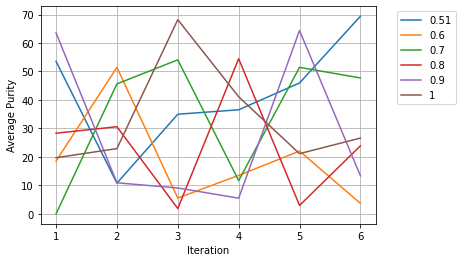

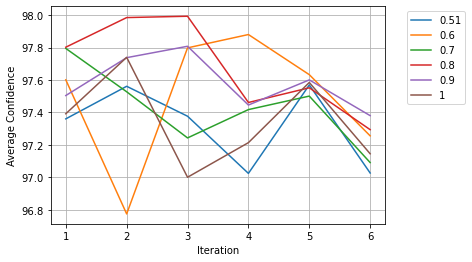

In [26]:
# k_labels = ["10", "20", "30", "40", "varying tn"]
# show_plot(range(1, 7), all_avg_purities,    "Iteration", "Average Purity", k_labels, saveAs="purity_varying_tn_2.png")
# show_plot(range(1, 7), all_avg_conf, "Iteration", "Average Confidence", k_labels, saveAs="confidence_varying_tn_1.png")

mu_labels = ["0.51", "0.6", "0.7", "0.8", "0.9", "1"]
show_plot(range(1, 6), np.array(all_avg_purities[5:]), "Iteration", "Average Purity", mu_labels, saveAs="purity_mu.png")
show_plot(range(1, 6), np.array(all_avg_conf[5:]), "Iteration", "Average Confidence", mu_labels, saveAs="confidence_mu.png")

In [24]:
len(all_avg_conf[0])

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


6

In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(baselineLDAModel, corpus, id2word)
pyLDAvis.save_html(vis, 'baselineLDA_mu.html')
vis

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.008873  0.008178       1        1  66.268172
13    -0.069442 -0.019999       2        1  13.187159
0     -0.020840 -0.090920       3        1   5.509679
11    -0.103441 -0.000461       4        1   4.492986
20    -0.073131 -0.070470       5        1   3.243282
2     -0.054682  0.052588       6        1   1.487321
18    -0.057999  0.057920       7        1   1.361081
23    -0.042270 -0.025071       8        1   1.003182
16    -0.043449 -0.016792       9        1   0.709306
9      0.060474  0.013502      10        1   0.582030
4     -0.012126  0.034627      11        1   0.223327
27     0.042459 -0.012295      12        1   0.219516
7      0.046445 -0.112296      13        1   0.191142
15     0.004097  0.049755      14        1   0.171752
6      0.002026  0.029554      15        1   0.145925
3     -0.009191  0.021855      16        1   0.124709
12     0.031809  0.005781      17        1   0.123239
1     -0.003778  0.016646      18        1   0.121728
24     0.043246  0.009831      19        1   0.099225
17     0.049611 -0.014983      20        1   0.095162
25     0.016997  0.008411      21        1   0.091665
29     0.022577 -0.010015      22        1   0.088866
28     0.014088  0.003266      23        1   0.085511
14     0.041850  0.017394      24        1   0.078628
22     0.019192 -0.013895      25        1   0.069807
8      0.014502  0.030563      26        1   0.058770
19     0.023315  0.017415      27        1   0.045826
21     0.018519 -0.016257      28        1   0.045565
10     0.013817  0.014922      29        1   0.042378
26     0.016450  0.011248      30        1   0.033061, topic_info=           Term         Freq        Total Category  logprob  loglift
2613  lieberman  1324.000000  1324.000000  Default  30.0000  30.0000
52        would  2458.000000  2458.000000  Default  29.0000  29.0000
79      clinton  2066.000000  2066.000000  Default  28.0000  28.0000
798      debate  2741.000000  2741.000000  Default  27.0000  27.0000
74     campaign  2370.000000  2370.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
575       early     0.721458   427.967955  Topic30  -5.8113   1.6290
740        news     0.789960   896.825892  Topic30  -5.7206   0.9799
474    american     0.761989  1355.749420  Topic30  -5.7566   0.5306
1714    success     0.616595   222.806990  Topic30  -5.9684   2.1247
26          one     0.631194  1789.697981  Topic30  -5.9450   0.0646

[1658 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1395      1  0.024765  abandoned
1395      2  0.024765  abandoned
1395      3  0.247645  abandoned
1395      4  0.148587  abandoned
1395      5  0.222881  abandoned
...     ...       ...        ...
763      19  0.000899       york
763      20  0.001797       york
763      21  0.000899       york
763      25  0.000899       york
763      29  0.000899       york

[10564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 14, 1, 12, 21, 3, 19, 24, 17, 10, 5, 28, 8, 16, 7, 4, 13, 2, 25, 18, 26, 30, 29, 15, 23, 9, 20, 22, 11, 27])

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda_mu.html')
vis

/home/jagaskak/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
27    -0.020373  0.002768       1        1  39.458706
16     0.064223 -0.000282       2        1  11.630580
24     0.032362  0.009459       3        1  10.012266
25     0.014900  0.035314       4        1   6.624467
2      0.059140  0.106123       5        1   5.648330
13     0.044162 -0.053726       6        1   5.337727
6     -0.002299 -0.045254       7        1   4.953349
3      0.030388 -0.083076       8        1   4.204006
5      0.051209 -0.012561       9        1   2.005290
15    -0.036091  0.006586      10        1   1.633568
4     -0.001691  0.017985      11        1   1.526134
10    -0.004398 -0.064308      12        1   1.222266
9      0.004924 -0.053615      13        1   1.201185
21    -0.031627 -0.015715      14        1   0.676367
17    -0.030592  0.018528      15        1   0.612750
20     0.016994  0.002683      16        1   0.495090
22     0.035665  0.010331      17        1   0.486612
23     0.055794 -0.011736      18        1   0.368472
29    -0.013052  0.041871      19        1   0.335118
1     -0.042409 -0.045001      20        1   0.248015
8     -0.062776  0.060961      21        1   0.184155
11    -0.000312  0.009346      22        1   0.171448
7     -0.013487 -0.027860      23        1   0.166345
12    -0.042633 -0.004664      24        1   0.166223
28     0.022243 -0.045543      25        1   0.123839
18     0.057252  0.109605      26        1   0.112757
14     0.024879  0.002058      27        1   0.112227
26    -0.067518  0.000934      28        1   0.102928
19    -0.144734  0.030365      29        1   0.098140
0     -0.000142 -0.001574      30        1   0.081641, topic_info=           Term         Freq        Total Category  logprob  loglift
2613  lieberman  1384.000000  1384.000000  Default  30.0000  30.0000
2448     string  1234.000000  1234.000000  Default  29.0000  29.0000
79      clinton  2156.000000  2156.000000  Default  28.0000  28.0000
74     campaign  2464.000000  2464.000000  Default  27.0000  27.0000
52        would  2298.000000  2298.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
423       party     1.568961  1494.100866  Topic30  -5.9384   0.2517
33    president     1.551067  1909.865205  Topic30  -5.9498  -0.0053
889     several     1.445373   752.270097  Topic30  -6.0204   0.8559
190       today     1.472960  1477.353301  Topic30  -6.0015   0.1999
524      people     1.451685  1578.644994  Topic30  -6.0161   0.1190

[1806 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
717       3  0.138679   abc
717       4  0.062406   abc
717       5  0.062406   abc
717       6  0.041604   abc
717       7  0.194151   abc
...     ...       ...   ...
763      25  0.002344  york
763      26  0.001172  york
763      27  0.002344  york
763      28  0.001172  york
763      29  0.001172  york

[15011 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 17, 25, 26, 3, 14, 7, 4, 6, 16, 5, 11, 10, 22, 18, 21, 23, 24, 30, 2, 9, 12, 8, 13, 29, 19, 15, 27, 20, 1])

In [ ]:
p = pyLDAvis.gensim.prepare(topic_model, corpus, dictionary)
pyLDAvis.save_html(p, 'lda.html')